In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import warnings
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder

import glob

# Define the directory path where the CSV files are located
input_path =r'../data/promice/preprocessed/South_West/'
pattern = '*.csv'
#staion_list = ['SCO_L.csv','KAN_L.csv']

# Use glob to get a list of all files that match the pattern
filenames = glob.glob(input_path + pattern)


data_collection = []
for file in filenames:
    data = pd.read_csv(file, index_col=False)
    data_collection.append(data)
data = pd.concat(data_collection)

data = data.reset_index(drop=True)


#data = pd.read_csv('../data//promice/preprocessed/daily/SCO_L.csv')
data = data.drop(['Unnamed: 0','Surface height from combined measurements DELTA', 'Surface height from combined measurements'], axis=1)
data['Datetime'] = pd.to_datetime(data['Datetime'], format='%Y-%m-%d')

In [2]:

def add_features(data):
    df = data.copy()
    df['DayOfYear'] = df['Datetime'].dt.dayofyear
    df['WeekNum'] = df['Datetime'].dt.isocalendar().week.astype(int)
    df['Month'] = df['Datetime'].dt.month
    df['Year'] = df['Datetime'].dt.year
    return df

data = add_features(data)


# Calculating Melt Season Start

In [3]:
def create_lagged_features(df, n_lags):

    lagged_df = pd.DataFrame()
    

    for i in df.columns:
        for j in range(1,n_lags+1):
            lagged_df[f'{i}_lag_{j}'] = df[i].shift(j).copy()

    return lagged_df.copy()

# function that populates event and time to event data
def  time_to_event_calc(df, year_data, event):
    
    #print(df.loc[df.index.year].shape)
    print(year_data['Year'].unique()[0])
    

    return df



def results_summary(df, results):
    results_df = results.copy()
    
    #results_df = results_df.loc[results.index]
    results_df['pred_date'] = results_df['DayOfYear'] + results_df['xgb_pred']
    results_df['event'] = df['event']
    results_df['event_date'] = 0
    results_df.set_index(results_df['Datetime'], inplace=True)
    
    test_years = results['Datetime'].dt.year.unique()
    

#display(results)
    #weekly_data = results_df['pred_date'].resample('W').mean() 
    monthly_data = results_df['pred_date'].resample('M').mean().round(1)
    quarterly_data = results_df['pred_date'].resample('Q').mean().round(1)
    yearly_data = results_df['pred_date'].resample('Y').mean().round(1)

    result_agg = pd.concat([monthly_data, quarterly_data,yearly_data], axis=1,keys=['Monthly','Quarterly','Yearly'])
    result_agg = result_agg.merge(results_df['event_date'], how='left',left_index=True,right_index=True)
    result_agg = result_agg.loc[((result_agg.index.year).isin(test_years))]

    result_agg = result_agg.dropna(how='all')

    for year in test_years:
        event = results_df.loc[(results_df['Year'] == year) & (results_df['event'] == 1),'DayOfYear']
        result_agg.loc[result_agg.index.year == year,['event_date']] = int(event)
    
    result_agg[''] = '|'
    result_agg['Month_diff'] = (result_agg['Monthly'] - result_agg['event_date']).round(1)
    result_agg['Quarter_diff'] = (result_agg['Quarterly'] - result_agg['event_date']).round(1)
    result_agg['Year_diff'] = (result_agg['Yearly'] - result_agg['event_date']).round(1)

    result_agg.index = result_agg.index.strftime('%Y-%m-%d')
    result_agg.fillna('',inplace=True)

    return result_agg


def results_summary_new(df, results):
    results_df = results.copy()

    results_df['pred_date'] = results_df['Datetime'] + pd.to_timedelta(results_df['xgb_pred'], unit='D')
    results_df['pred_date_DOY'] = results_df['DayOfYear'] + results_df['xgb_pred']
    results_df['event'] = df['event']
    results_df['event_date'] = 0
    results_df.set_index(results_df['Datetime'], inplace=True)
    #display(results_df)

    test_years = results['Datetime'].dt.year.unique()


    # Date data 
    monthly_data = results_df['pred_date'].resample('M').apply(lambda x: pd.to_datetime(x.astype('int64').mean()))
    quarterly_data = results_df['pred_date'].resample('Q').apply(lambda x: pd.to_datetime(x.astype('int64').mean()))
    yearly_data = results_df['pred_date'].resample('Y').apply(lambda x: pd.to_datetime(x.astype('int64').mean()))

    result_agg = pd.concat([monthly_data, quarterly_data, yearly_data], axis=1, keys=['Monthly', 'Quarterly', 'Yearly'])
    result_agg = result_agg.merge(results_df['event_date'], how='left', left_index=True, right_index=True)
    result_agg = result_agg.loc[((result_agg.index.year).isin(test_years))]

    # Day of Year data
    #monthly_data = results_df['pred_date_DOY'].resample('M').mean()
    #quarterly_data = results_df['pred_date_DOY'].resample('Q').mean()
    #yearly_data = results_df['pred_date_DOY'].resample('Y').mean()
    #print(yearly_data)

    #result_agg_DOY = pd.concat([monthly_data, quarterly_data,yearly_data], axis=1,keys=['Monthly','Quarterly','Yearly'])
    #result_agg_DOY = result_agg.merge(results_df['event_date'], how='left',left_index=True,right_index=True)
    #result_agg_DOY = result_agg.loc[((result_agg.index.year).isin(test_years))]
    #display(result_agg_DOY)

    result_agg = result_agg.dropna(how='all')
    result_agg_DOY = result_agg.dropna(how='all')

    for year in test_years:
        event = results_df.loc[(results_df['Year'] == year) & (results_df['event'] == 1)].index
        #print(event)
        #event = results_df.loc[(results_df['Year'] == year) & (results_df['event'] == 1), 'DayOfYear']
        #print(event)
        result_agg.loc[result_agg.index.year == year, ['event_date']] = pd.to_datetime(event)
    #display(result_agg)
        #result_agg_DOY.loc[result_agg.index.year == year,['event_date']] = int(event)
    result_agg['event_date'] = pd.to_datetime(result_agg['event_date'])
    result_agg[''] = '|'
    result_agg['Month_diff'] = (result_agg['Monthly'].dt.tz_localize(None) - result_agg['event_date'].dt.tz_localize(None)).apply(lambda x: x.days)
    result_agg['Quarter_diff'] = (result_agg['Quarterly'].dt.tz_localize(None) - result_agg['event_date'].dt.tz_localize(None)).apply(lambda x: x.days)
    result_agg['Year_diff'] = (result_agg['Yearly'].dt.tz_localize(None) - result_agg['event_date'].dt.tz_localize(None)).apply(lambda x: x.days)
    for col in result_agg.columns:
        try:
            result_agg[col] = result_agg[col].strftime('%Y-%m-%d')
        except:
            pass

    result_agg.index = result_agg.index.strftime('%Y-%m-%d')
    #result_agg.fillna('', inplace=True)
    #for col in result_agg.columns:
    #    result_agg[col] - result_agg[col].apply(lambda x: np.nan if pd.isnull(x) else x)
    result_agg.replace({np.nan:'',pd.NaT:''}, inplace = True)
    
    return result_agg



def summarize_results_by_stid(df, results):
    combined_results = []

    for stid, group in results.groupby('stid'):
        group_results = results_summary(df[df['stid'] == stid], group)
        group_results['stid'] = stid
        combined_results.append(group_results)

    combined_df = pd.concat(combined_results, axis=1, keys=[result['stid'].iloc[0] for result in combined_results])
    combined_df.fillna('')
    return combined_df

#summary = summarize_results_by_stid(df, results)
#display(summary.head(30))


In [4]:
from sklearn.preprocessing import LabelEncoder

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

def preprocessing_melt(data, start_end='start', lags=False):
    # Preprocessing 
    df = data.copy()
    df = df.bfill()

    #create event and time to event columns
    df['event'] = 0
    df['event_True'] = 0
    df.loc[:,'event_True'] = True
    df['time_to_event'] = 0



    # min/max scaling
    train_columns = df.drop(['stid','Datetime','Ablation','Melting Season','WeekNum','Month','Year','time_to_event', 'event', 'event_True', 'DayOfYear'],axis=1).columns
    scaler = MinMaxScaler()
    df[train_columns] = scaler.fit_transform(df[train_columns])

    # include lags if not False and specify features/target columns
    if type(lags) == int:
        lagged_features = create_lagged_features(df[train_columns], lags)
        features = pd.merge(df[train_columns], lagged_features, how='left', left_index=True, right_index=True)

    elif not lags:
        features = df[train_columns]
    else:
        raise ValueError('Lags input not accepted, needs to be False or int')
    

    #display(features)
    #display(df)
    label_encoder = LabelEncoder()
    label_df = pd.DataFrame()
    label_df['station_encoded'] = label_encoder.fit_transform(df['stid']).copy()
    label_df['year_encoded'] = label_encoder.fit_transform(df['Year']).copy()
    label_df.index = df.index.copy()
    features['station_encoded'] = label_df['station_encoded'].copy()
    features['year_encoded'] = label_df['year_encoded'].copy()
    features[['station_encoded','year_encoded']] = scaler.fit_transform(features[['station_encoded','year_encoded']]).copy()
    
    # calculate event date and time to event per year
    for station in df['stid'].unique():
        


        unique_years = df.loc[df['stid'] == station,'Year'].unique()
        for year in unique_years:
            # Filter data for the current year
            year_data = df[(df['stid'] == station) & (df['Year'] == year)]

            if start_end == 'start':
                event = year_data.loc[year_data['Ablation'] == True]['Datetime'].min()
                #df.loc[df.index.year == year, ['time_to_event']] = (year_data.index - event).astype('timedelta64[D]')
                        
            elif start_end == 'end':
                event = year_data.loc[year_data['Ablation'] == True]['Datetime'].max()

            df.loc[(df['stid'] == station) & (df['Datetime'] == event),['event']] = 1
            df.loc[(df['Year'] == year) & (df['stid'] == station), ['time_to_event']] = (event - year_data['Datetime']).astype('timedelta64[D]')

        # filter out first and last year for each station for data completion
        max_year, min_year = df.loc[df['stid'] == station,'Year'].max(), df.loc[df['stid'] == station,'Year'].min()
        year_filter = df.loc[(df['stid'] == station) & ((df['Year'] == max_year) | (df['Year'] == min_year))].index
        df = df.loc[~df.index.isin(year_filter)]
        print('filtered out for station',station, 'max_year', max_year, 'min_year', min_year)



    #filter relevant period
    if start_end == 'start':
        df = df.loc[df['time_to_event'] >= 0]
    elif start_end == 'end':
        df = df.loc[df['Ablation'] == True]
        #df = df.loc[(df['Month'] >= 5) & (df['Month'] <= 10)]

    
    #drop NaN values and align features/target so they have same dates
    target = df[['event', 'event_True', 'time_to_event']].copy()

    #label_encoder.fit_transform(features

    features.dropna(inplace=True)
    target.dropna(inplace=True)
    
    common_index = features.index.intersection(target.index)
    features = features.loc[common_index]
    target = target.loc[common_index]

    return df, features, target

df, features, target = preprocessing_melt(data, start_end='start',lags=14)
display(features)


filtered out for station KAN_L max_year 2023 min_year 2008
filtered out for station NUK_L max_year 2023 min_year 2007
filtered out for station NUK_U max_year 2022 min_year 2007
filtered out for station QAS_L max_year 2023 min_year 2007
filtered out for station QAS_U max_year 2023 min_year 2008


,Air pressure (upper boom),Air temperature (upper boom),Relative humidity (upper boom) - corrected,Specific humidity (upper boom),Wind speed (upper boom),Wind from direction (upper boom),Downwelling shortwave radiation - corrected,Upwelling shortwave radiation - corrected,Downwelling longwave radiation,Upwelling longwave radiation,...,Cloud cover_lag_7,Cloud cover_lag_8,Cloud cover_lag_9,Cloud cover_lag_10,Cloud cover_lag_11,Cloud cover_lag_12,Cloud cover_lag_13,Cloud cover_lag_14,station_encoded,year_encoded
122,0.783948,0.627544,0.614515,0.233504,0.361774,0.407407,0.001386,0.001379,0.281518,0.583373,...,0.312583,0.774667,0.970000,0.978250,0.909708,0.360250,0.294625,0.465375,0.0,0.1250
123,0.780782,0.705490,0.622504,0.326606,0.251026,0.385849,0.001585,0.001573,0.348692,0.617943,...,0.590417,0.312583,0.774667,0.970000,0.978250,0.909708,0.360250,0.294625,0.0,0.1250
124,0.782836,0.640127,0.787592,0.314023,0.100557,0.334979,0.001688,0.001671,0.370716,0.591702,...,0.538542,0.590417,0.312583,0.774667,0.970000,0.978250,0.909708,0.360250,0.0,0.1250
125,0.777060,0.504223,0.961577,0.218582,0.059101,0.237554,0.001316,0.001300,0.360916,0.542649,...,0.898292,0.538542,0.590417,0.312583,0.774667,0.970000,0.978250,0.909708,0.0,0.1250
126,0.765920,0.594760,0.832187,0.280022,0.188454,0.318150,0.001487,0.001466,0.343124,0.577472,...,0.193083,0.898292,0.538542,0.590417,0.312583,0.774667,0.970000,0.978250,0.0,0.1250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27218,0.712642,0.776711,0.219306,0.157190,0.195656,0.190856,0.246939,0.261900,0.600398,0.693774,...,0.948042,0.739792,0.106708,0.336833,0.441250,0.045833,0.856292,0.650625,1.0,0.9375
27219,0.701932,0.748526,0.054659,0.034025,0.246989,0.226236,0.299989,0.337926,0.584851,0.692636,...,1.000000,0.948042,0.739792,0.106708,0.336833,0.441250,0.045833,0.856292,1.0,0.9375
27220,0.716900,0.751628,0.164522,0.100221,0.071336,0.210448,0.460825,0.434875,0.502361,0.696380,...,0.998542,1.000000,0.948042,0.739792,0.106708,0.336833,0.441250,0.045833,1.0,0.9375
27221,0.700699,0.770070,0.000000,0.000000,0.267525,0.190470,0.152438,0.173516,0.588418,0.691292,...,0.220833,0.998542,1.000000,0.948042,0.739792,0.106708,0.336833,0.441250,1.0,0.9375


In [5]:
#display(df.loc[df['event'] == True])


In [6]:
def custom_train_test_split(df, features, target, method='by_year'):
    
    if method == 'by_year':
        
        num_stations = df['stid'].nunique()
        st_count_by_year = df.groupby('Year')['stid'].nunique()
        common_years = st_count_by_year[st_count_by_year == num_stations].index

        train_years, test_years = train_test_split(common_years, test_size=0.2, random_state=2023)

        train = df.loc[~df['Year'].isin(test_years)].index
        test = df.loc[df['Year'].isin(test_years)].index

        X_train = features.loc[features.index.isin(train)]
        y_train = target.loc[target.index.isin(train)]
        X_test = features.loc[features.index.isin(test)]
        y_test = target.loc[features.index.isin(test)]

    elif method == 'standard_train_test':
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False, random_state=42)

    else:
        raise ValueError('by_year variable must be True or False')

    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = custom_train_test_split(df, features, target, method='by_year')
display(y_test)


,event,event_True,time_to_event
1217,0,True,131.0
1218,0,True,130.0
1219,0,True,129.0
1220,0,True,128.0
1221,0,True,127.0
...,...,...,...
25798,0,True,4.0
25799,0,True,3.0
25800,0,True,2.0
25801,0,True,1.0


# XGB Regressor models

In [14]:
df, features, target = preprocessing_melt(data, start_end='start',lags=7)
X_train, X_test, y_train, y_test = custom_train_test_split(df, features, target, method='by_year')


xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=3,
    min_child_weight=5,
    learning_rate=0.01,
    n_estimators=400,
    subsample=0.5,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=0.5,
    early_stopping_rounds=20)


#xgb_model.fit(X_train, y_train['time_to_event'])

xgb_model.fit(X_train, y_train['time_to_event'],
        eval_set=[(X_train, y_train['time_to_event']),(X_test,y_test['time_to_event'])],
        verbose=50)

xgb_pred_train = xgb_model.predict(X_train)
xgb_pred_test = xgb_model.predict(X_test)

print("XGBoost MAE - Train:", mean_absolute_error(y_train['time_to_event'], xgb_pred_train))
print("XGBoost MAE - Test:", mean_absolute_error(y_test['time_to_event'], xgb_pred_test))
print("XGBoost MSE - Train:", mean_squared_error(y_train['time_to_event'], xgb_pred_train))
print("XGBoost MSE - Test:", mean_squared_error(y_test['time_to_event'], xgb_pred_test))
print("XGBoost R2 - Train:", r2_score(y_train['time_to_event'], xgb_pred_train))
print("XGBoost R2 - Test:", r2_score(y_test['time_to_event'], xgb_pred_test))



filtered out for station KAN_L max_year 2023 min_year 2008
filtered out for station NUK_L max_year 2023 min_year 2007
filtered out for station NUK_U max_year 2022 min_year 2007
filtered out for station QAS_L max_year 2023 min_year 2007
filtered out for station QAS_U max_year 2023 min_year 2008
[0]	validation_0-rmse:96.31702	validation_1-rmse:98.34078
[50]	validation_0-rmse:64.69855	validation_1-rmse:67.50448
[100]	validation_0-rmse:47.11675	validation_1-rmse:50.96667
[150]	validation_0-rmse:37.32559	validation_1-rmse:42.07068
[200]	validation_0-rmse:32.06101	validation_1-rmse:37.60864
[250]	validation_0-rmse:29.11863	validation_1-rmse:35.26732
[300]	validation_0-rmse:27.44997	validation_1-rmse:34.00885
[350]	validation_0-rmse:26.35790	validation_1-rmse:33.29070
[399]	validation_0-rmse:25.57151	validation_1-rmse:32.94477
XGBoost MAE - Train: 18.512411037296186
XGBoost MAE - Test: 25.31934917159916
XGBoost MSE - Train: 653.9020642004598
XGBoost MSE - Test: 1085.3577239745703
XGBoost R2 -

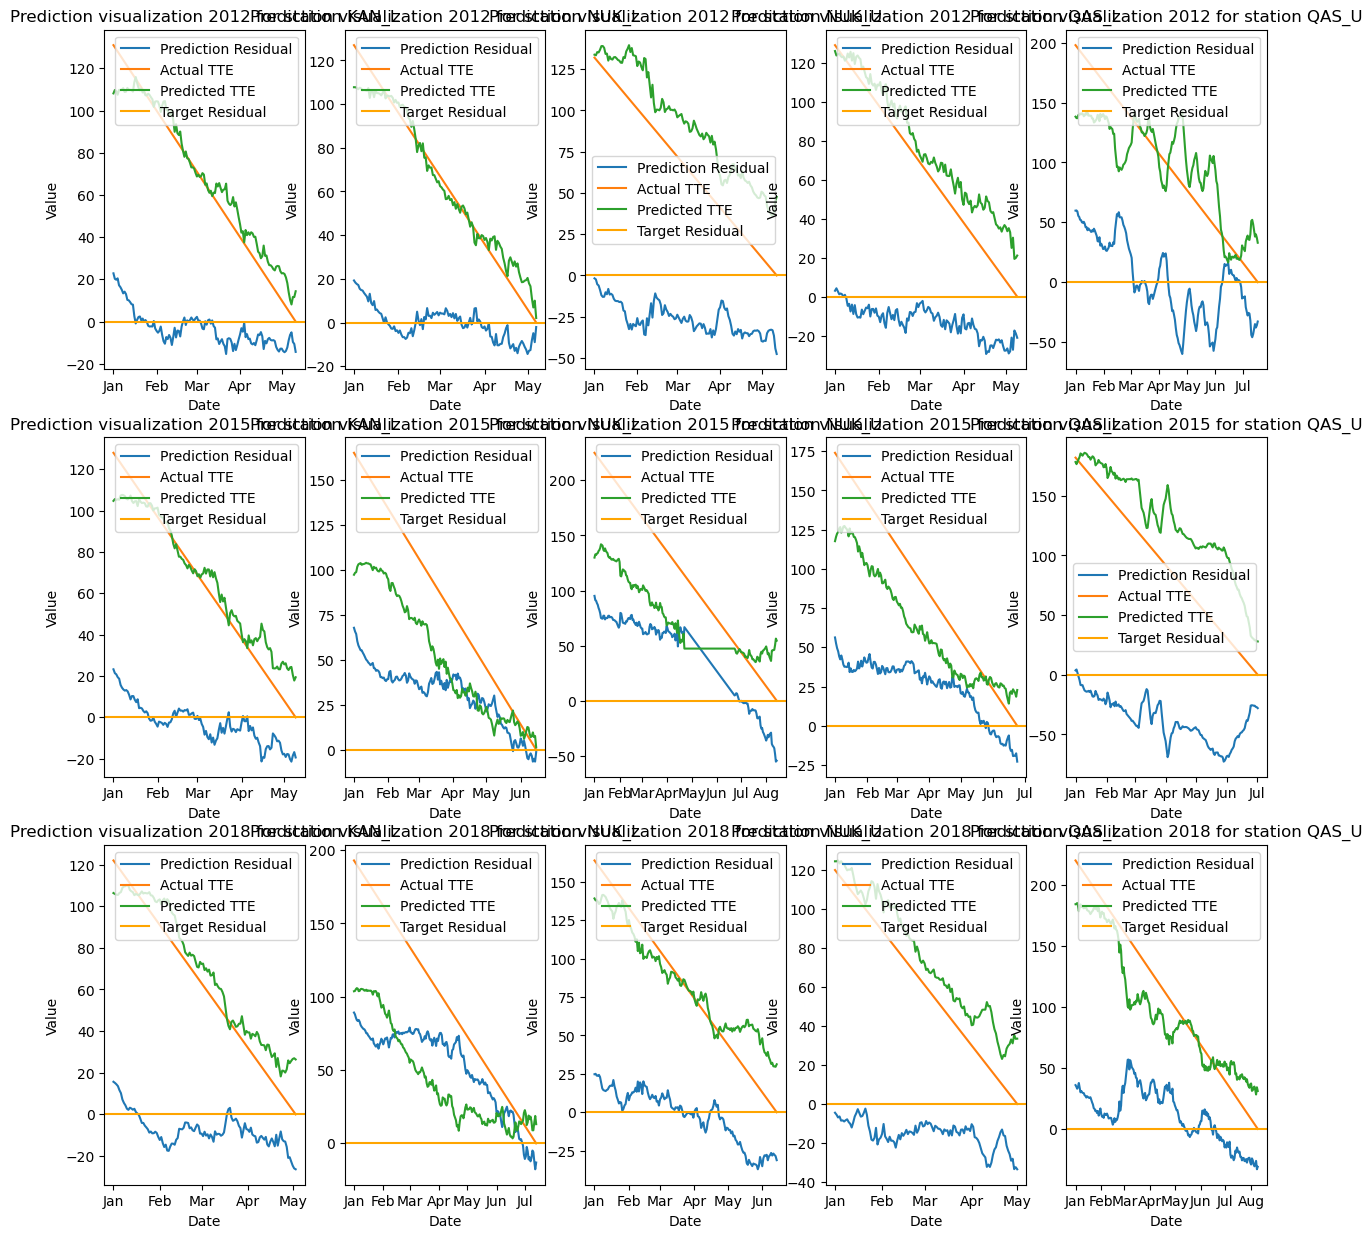

<Axes: title={'center': 'Feature Importance'}>

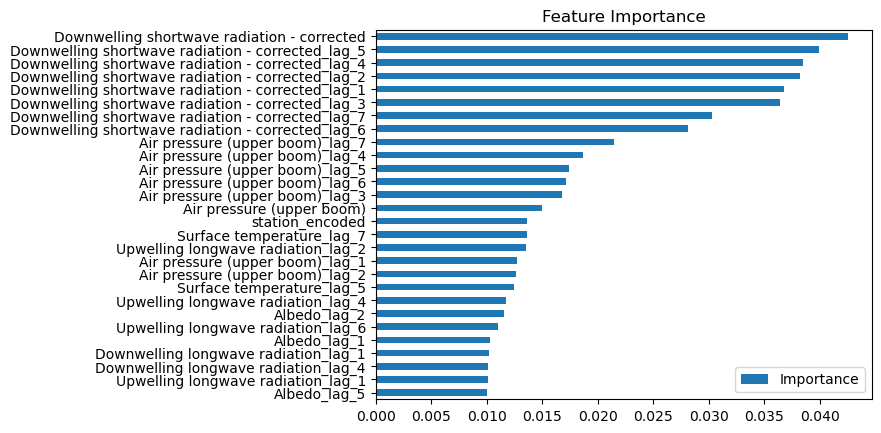

In [15]:
import matplotlib.dates as mdates

results = y_test['time_to_event'].to_frame()
results['xgb_pred'] = xgb_pred_test
results = results.sort_index()
#display(results)
results['diff'] = results['time_to_event'] - results['xgb_pred']

results[['Datetime','Year','stid','DayOfYear']] = df[['Datetime','Year','stid', 'DayOfYear']]
doy_group = df.groupby(['DayOfYear'])['time_to_event'].mean()
results = results.merge(doy_group, how='left',left_on='DayOfYear',right_on=doy_group.index).set_index(results.index)
results.rename(columns={'time_to_event_x':'time_to_event','time_to_event_y':'avg_time_to_event'},inplace=True)



sample_years = sorted(np.unique(results['Year']))
stations = results['stid'].unique()

fig, axes = plt.subplots(len(sample_years), len(stations), figsize=(15, len(sample_years) * 5))

for row, sample_year in enumerate(sample_years):
        for col, station in enumerate(stations):
                ax = axes[row, col]
                df_year_station = results.loc[(results['Year'] == sample_year) & (results['stid'] == station)]
                

                ax.plot(df_year_station['Datetime'], df_year_station['diff'], label = 'Prediction Residual')
                ax.plot(df_year_station['Datetime'], df_year_station['time_to_event'], label = 'Actual TTE')
                ax.plot(df_year_station['Datetime'], df_year_station['xgb_pred'], label = 'Predicted TTE')
                #ax.plot(df_year_station['Datetime'], df_year_station['avg_time_to_event'], label = 'Avg TTE')

                ax.axhline(y=0, label='Target Residual', color='orange')
                ax.set_xlabel('Date')
                ax.set_ylabel('Value')
                ax.set_title(f'Prediction visualization {sample_year} for station {station}')
                ax.legend()
                        # Configure the x-axis to display only months
                ax.xaxis.set_major_locator(mdates.MonthLocator())
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.show()


f1 = pd.DataFrame(data=xgb_model.feature_importances_,
        index=xgb_model.feature_names_in_,
        columns=['Importance'])
f1 = f1.loc[f1['Importance'] > 0.01]
f1.sort_values('Importance').plot(kind='barh',title='Feature Importance')




,importance sum,importance lag max
Downwelling shortwave radiation - corrected,0.338078,0.072131
Latent heat flux (upper boom),0.145728,0.030023
Upwelling shortwave radiation - corrected,0.123072,0.022913
Wind speed (upper boom),0.089029,0.014191
Wind from direction (upper boom),0.087408,0.016802
Air temperature (upper boom),0.045983,0.007335
Surface temperature,0.038235,0.008332
Specific humidity (upper boom),0.031248,0.007461
Upwelling longwave radiation,0.030212,0.014506
Albedo,0.026828,0.006275


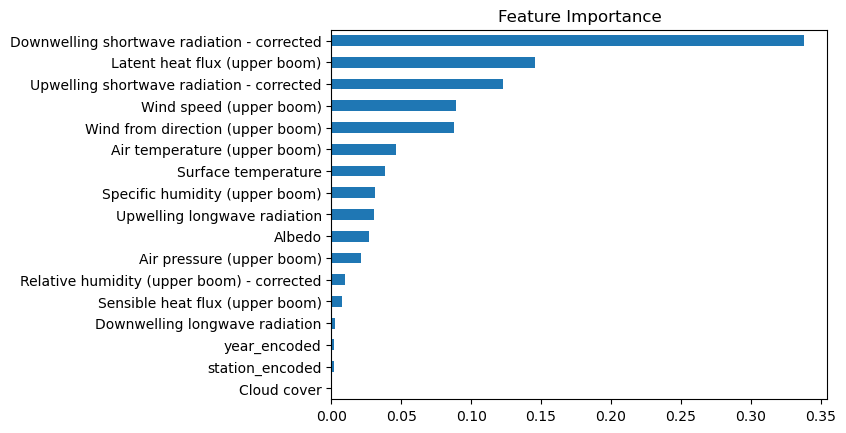

,importance sum,importance lag max
Downwelling shortwave radiation - corrected,0.338078,0.072131
Latent heat flux (upper boom),0.145728,0.030023
Upwelling shortwave radiation - corrected,0.123072,0.022913
Wind speed (upper boom),0.089029,0.014191
Wind from direction (upper boom),0.087408,0.016802
Air temperature (upper boom),0.045983,0.007335
Surface temperature,0.038235,0.008332
Specific humidity (upper boom),0.031248,0.007461
Upwelling longwave radiation,0.030212,0.014506
Albedo,0.026828,0.006275


In [18]:

f1 = pd.DataFrame(data=xgb_model.feature_importances_,
        index=xgb_model.feature_names_in_,
        columns=['Importance'])

#f1['feature'] = f1.index
#display(f1)


feature_importance_agg = pd.DataFrame()
feature_importance_agg['importance sum'] = f1.groupby(lambda x: x.split('_lag')[0]).sum().sort_values(by='Importance', ascending=False)
feature_importance_agg['importance lag max'] = f1.groupby(lambda x: x.split('_lag')[0]).max()

import re

feature_importance_agg['importance sum'] = f1.groupby(lambda x: x.split('_lag')[0]).sum().sort_values(by='Importance', ascending=False)
feature_importance_agg['importance lag max'] = f1.groupby(lambda x: x.split('_lag')[0]).max()

def extract_lag_number(x):
    match = re.search(r'_lag_(\d+)', x)
    #if not match:
    #    print(f'No match found for: {x}')
    return int(match.group(1)) if match else 0

max_lag_importance = f1.groupby(lambda x: x.split('_lag')[0]).idxmax().applymap(extract_lag_number)

display(feature_importance_agg)


feature_importance_agg['importance sum'].sort_values(ascending=True).plot(kind='barh',title='Feature Importance')
plt.show()
display(feature_importance_agg)

In [9]:
summary = summarize_results_by_stid(df, results)
display(summary)

KAN_L                                                           \
           Monthly Quarterly Yearly event_date      Month_diff Quarter_diff   
Datetime                                                                      
2012-01-31   125.0                       132.0    |       -7.0                
2012-02-29   135.9                       132.0    |        3.9                
2012-03-31   138.0     132.9             132.0    |        6.0          0.9   
2012-04-30   140.6                       132.0    |        8.6                
2012-05-31   143.1                       132.0    |       11.1                
2012-06-30             141.3             132.0    |                     9.3   
2012-12-31                    135.5      132.0    |                           
2015-01-31   120.4                       129.0    |       -8.6                
2015-02-28   128.8                       129.0    |       -0.2                
2015-03-31   135.1     128.1             129.0    |        6.1         -0.9   
2015-04-30   139.4                       129.0    |       10.4                
2015-05-31   147.7                       129.0    |       18.7                
2015-06-30             141.3             129.0    |                    12.3   
2015-12-31                    132.1      129.0    |                           
2018-01-31   122.3                       123.0    |       -0.7                
2018-02-28   132.9                       123.0    |        9.9                
2018-03-31   129.8     128.2             123.0    |        6.8          5.2   
2018-04-30   135.7                       123.0    |       12.7                
2018-05-31   148.7                       123.0    |       25.7                
2018-06-30             136.9             123.0    |                    13.9   
2018-12-31                    130.5      123.0    |                           
2018-07-31     NaN       NaN    NaN        NaN  NaN        NaN          NaN   
2018-09-30     NaN       NaN    NaN        NaN  NaN        NaN          NaN   
2015-07-31     NaN       NaN    NaN        NaN  NaN        NaN          NaN   
2015-08-31     NaN       NaN    NaN        NaN  NaN        NaN          NaN   
2015-09-30     NaN       NaN    NaN        NaN  NaN        NaN          NaN   
2012-07-31     NaN       NaN    NaN        NaN  NaN        NaN          NaN   
2012-09-30     NaN       NaN    NaN        NaN  NaN        NaN          NaN   
2018-08-31     NaN       NaN    NaN        NaN  NaN        NaN          NaN   

                              NUK_L  ...  QAS_L   QAS_U                   \
           Year_diff   stid Monthly  ...   stid Monthly Quarterly Yearly   
Datetime                             ...                                   
2012-01-31            KAN_L   121.0  ...  QAS_L   154.5                    
2012-02-29            KAN_L   128.8  ...  QAS_L   159.9                    
2012-03-31            KAN_L   126.2  ...  QAS_L   202.3     172.5          
2012-04-30            KAN_L   136.2  ...  QAS_L   216.5                    
2012-05-31            KAN_L   137.1  ...  QAS_L   229.5                    
2012-06-30            KAN_L          ...  QAS_L   201.3     215.9          
2012-12-31       3.5  KAN_L          ...  QAS_L                    197.2   
2015-01-31            KAN_L   116.9  ...  QAS_L   196.4                    
2015-02-28            KAN_L   126.4  ...  QAS_L   211.3                    
2015-03-31            KAN_L   129.7  ...  QAS_L   214.0     207.1          
2015-04-30            KAN_L   134.6  ...  QAS_L   230.6                    
2015-05-31            KAN_L   152.0  ...  QAS_L   242.9                    
2015-06-30            KAN_L   167.3  ...  QAS_L   230.0     234.6          
2015-12-31       3.1  KAN_L          ...  QAS_L                    220.8   
2018-01-31            KAN_L   118.9  ...  QAS_L   196.3                    
2018-02-28            KAN_L   120.7  ...  QAS_L   208.3                    
2018-03-31            KAN_L   120.8  ...

# Calculating melt season end
-------------------------------------


In [17]:
df, features, target = preprocessing_melt(data, start_end='end',lags=7)
X_train, X_test, y_train, y_test = custom_train_test_split(df, features, target, method='by_year')


xgb_model = xgb.XGBRegressor(
   objective='reg:squarederror',
   max_depth=3,
   min_child_weight=5,
   learning_rate=0.01,
   n_estimators=400,
   subsample=0.5,
   colsample_bytree=0.8,
   reg_alpha=0.5,
   reg_lambda=0.5,
   early_stopping_rounds=20)




#xgb_model.fit(X_train, y_train['time_to_event'])

xgb_model.fit(X_train, y_train['time_to_event'],
        eval_set=[(X_train, y_train['time_to_event']),(X_test,y_test['time_to_event'])],
        verbose=10)

xgb_pred_train = xgb_model.predict(X_train)
xgb_pred_test = xgb_model.predict(X_test)

print("XGBoost MAE - Train:", mean_absolute_error(y_train['time_to_event'], xgb_pred_train))
print("XGBoost MAE - Test:", mean_absolute_error(y_test['time_to_event'], xgb_pred_test))
print("XGBoost MSE - Train:", mean_squared_error(y_train['time_to_event'], xgb_pred_train))
print("XGBoost MSE - Test:", mean_squared_error(y_test['time_to_event'], xgb_pred_test))
print("XGBoost R2 - Train:", r2_score(y_train['time_to_event'], xgb_pred_train))
print("XGBoost R2 - Test:", r2_score(y_test['time_to_event'], xgb_pred_test))



filtered out for station KAN_L max_year 2023 min_year 2008
filtered out for station NUK_L max_year 2023 min_year 2007
filtered out for station NUK_U max_year 2022 min_year 2007
filtered out for station QAS_L max_year 2023 min_year 2007
filtered out for station QAS_U max_year 2023 min_year 2008
[0]	validation_0-rmse:70.87247	validation_1-rmse:68.76921
[10]	validation_0-rmse:65.24185	validation_1-rmse:63.31490
[20]	validation_0-rmse:60.22717	validation_1-rmse:58.45985
[30]	validation_0-rmse:55.72327	validation_1-rmse:54.13698
[40]	validation_0-rmse:51.70753	validation_1-rmse:50.27293
[50]	validation_0-rmse:48.11683	validation_1-rmse:46.83609
[60]	validation_0-rmse:44.93070	validation_1-rmse:43.77844
[70]	validation_0-rmse:42.11045	validation_1-rmse:41.04640
[80]	validation_0-rmse:39.55873	validation_1-rmse:38.59090
[90]	validation_0-rmse:37.32637	validation_1-rmse:36.45054
[100]	validation_0-rmse:35.30994	validation_1-rmse:34.54293
[110]	validation_0-rmse:33.54451	validation_1-rmse:32.88

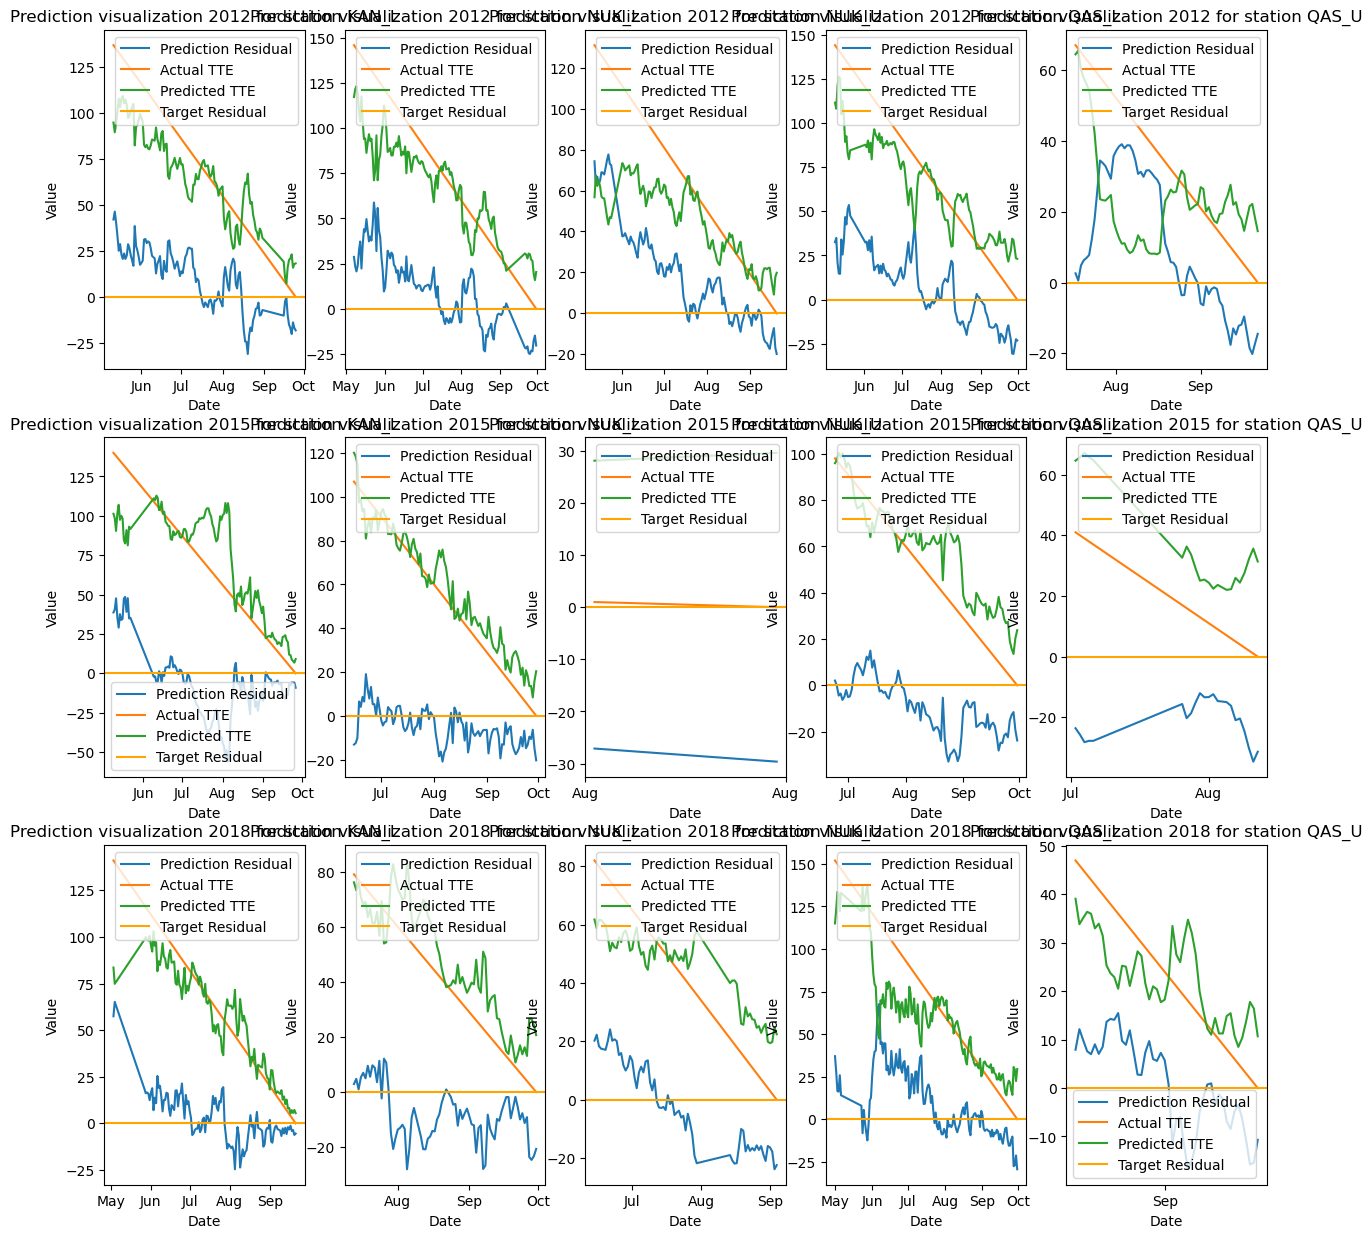

<Axes: title={'center': 'Feature Importance'}>

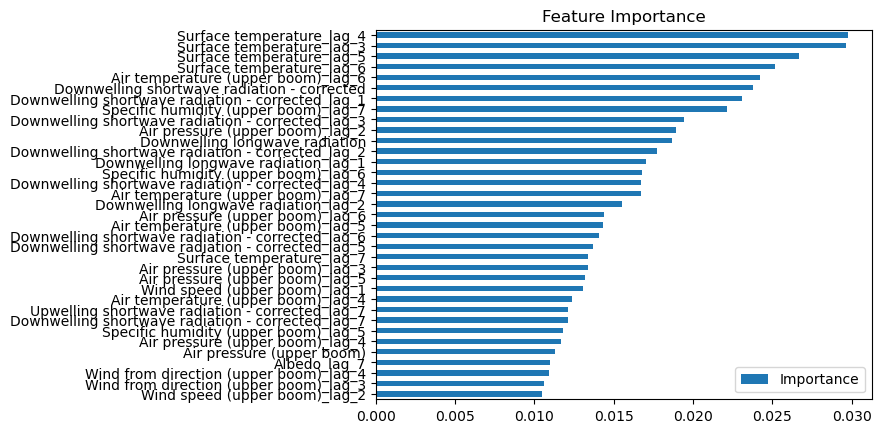

In [18]:
import matplotlib.dates as mdates

results = y_test['time_to_event'].to_frame()
results['xgb_pred'] = xgb_pred_test
results = results.sort_index()
#display(results)
results['diff'] = results['time_to_event'] - results['xgb_pred']

results[['Datetime','Year','stid','DayOfYear']] = df[['Datetime','Year','stid', 'DayOfYear']]
doy_group = df.groupby(['DayOfYear'])['time_to_event'].mean()
results = results.merge(doy_group, how='left',left_on='DayOfYear',right_on=doy_group.index).set_index(results.index)
results.rename(columns={'time_to_event_x':'time_to_event','time_to_event_y':'avg_time_to_event'},inplace=True)


sample_years = sorted(np.unique(results['Year']))
stations = results['stid'].unique()

fig, axes = plt.subplots(len(sample_years), len(stations), figsize=(15, len(sample_years) * 5))

for row, sample_year in enumerate(sample_years):
        for col, station in enumerate(stations):
                ax = axes[row, col]
                df_year_station = results.loc[(results['Year'] == sample_year) & (results['stid'] == station)]
                

                ax.plot(df_year_station['Datetime'], df_year_station['diff'], label = 'Prediction Residual')
                ax.plot(df_year_station['Datetime'], df_year_station['time_to_event'], label = 'Actual TTE')
                ax.plot(df_year_station['Datetime'], df_year_station['xgb_pred'], label = 'Predicted TTE')
                #ax.plot(df_year_station['Datetime'], df_year_station['avg_time_to_event'], label = 'Avg TTE')

                ax.axhline(y=0, label='Target Residual', color='orange')
                ax.set_xlabel('Date')
                ax.set_ylabel('Value')
                ax.set_title(f'Prediction visualization {sample_year} for station {station}')
                ax.legend()
                        # Configure the x-axis to display only months
                ax.xaxis.set_major_locator(mdates.MonthLocator())
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.show()


f1 = pd.DataFrame(data=xgb_model.feature_importances_,
        index=xgb_model.feature_names_in_,
        columns=['Importance'])
f1 = f1.loc[f1['Importance'] > 0.01]
f1.sort_values('Importance').plot(kind='barh',title='Feature Importance')




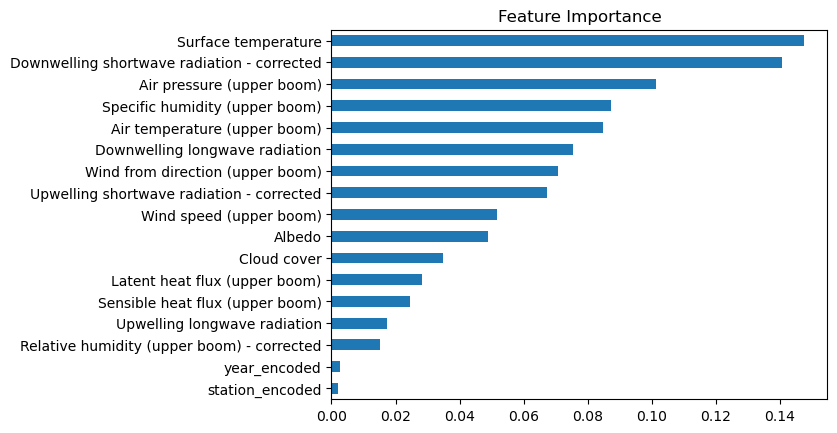

,importance sum,importance lag max,max_lag
Surface temperature,0.147422,0.029772,4
Downwelling shortwave radiation - corrected,0.140636,0.023795,0
Air pressure (upper boom),0.101259,0.018929,2
Specific humidity (upper boom),0.087121,0.022117,7
Air temperature (upper boom),0.084764,0.024211,6
Downwelling longwave radiation,0.075334,0.018668,0
Wind from direction (upper boom),0.070701,0.010890,4
Upwelling shortwave radiation - corrected,0.067404,0.012142,7
Wind speed (upper boom),0.051753,0.013063,1
Albedo,0.048789,0.010985,7


In [19]:

f1 = pd.DataFrame(data=xgb_model.feature_importances_,
        index=xgb_model.feature_names_in_,
        columns=['Importance'])

#f1['feature'] = f1.index
#display(f1)


feature_importance_agg = pd.DataFrame()
feature_importance_agg['importance sum'] = f1.groupby(lambda x: x.split('_lag')[0]).sum().sort_values(by='Importance', ascending=False)
feature_importance_agg['importance lag max'] = f1.groupby(lambda x: x.split('_lag')[0]).max()

import re

feature_importance_agg['importance sum'] = f1.groupby(lambda x: x.split('_lag')[0]).sum().sort_values(by='Importance', ascending=False)
feature_importance_agg['importance lag max'] = f1.groupby(lambda x: x.split('_lag')[0]).max()

def extract_lag_number(x):
    match = re.search(r'_lag_(\d+)', x)
    #if not match:
    #    print(f'No match found for: {x}')
    return int(match.group(1)) if match else 0

max_lag_importance = f1.groupby(lambda x: x.split('_lag')[0]).idxmax().applymap(extract_lag_number)

feature_importance_agg['max_lag'] = max_lag_importance.iloc[:, 0]



feature_importance_agg['importance sum'].sort_values(ascending=True).plot(kind='barh',title='Feature Importance')
plt.show()
display(feature_importance_agg)


In [20]:
summary = summarize_results_by_stid(df, results)
display(summary)

KAN_L                                                         \
           Monthly Quarterly Yearly event_date    Month_diff Quarter_diff   
Datetime                                                                    
2012-05-31   241.8                       269.0  |      -27.2                
2012-06-30   248.0     245.5             269.0  |      -21.0        -23.5   
2012-07-31   262.2                       269.0  |       -6.8                
2012-08-31   271.3                       269.0  |        2.3                
2012-09-30   281.4     268.8             269.0  |       12.4         -0.2   
2012-12-31                    259.1      269.0  |                           
2015-05-31   229.7                       269.0  |      -39.3                
2015-06-30   267.5     252.8             269.0  |       -1.5        -16.2   
2015-07-31   290.8                       269.0  |       21.8                
2015-08-31   288.6                       269.0  |       19.6                
2015-09-30   276.7     285.8             269.0  |        7.7         16.8   
2015-12-31                    276.3      269.0  |                           
2018-05-31   235.1                       264.0  |      -28.9                
2018-06-30   250.8     247.8             264.0  |      -13.2        -16.2   
2018-07-31   261.4                       264.0  |       -2.6                
2018-08-31   272.2                       264.0  |        8.2                
2018-09-30   268.1     267.1             264.0  |        4.1          3.1   
2018-12-31                    261.2      264.0  |                           

                              NUK_L  ...  QAS_L   QAS_U                   \
           Year_diff   stid Monthly  ...   stid Monthly Quarterly Yearly   
Datetime                             ...                                   
2012-05-31            KAN_L   237.7  ...  QAS_L     NaN       NaN    NaN   
2012-06-30            KAN_L   254.2  ...  QAS_L     NaN       NaN    NaN   
2012-07-31            KAN_L   270.5  ...  QAS_L   247.2                    
2012-08-31            KAN_L   275.3  ...  QAS_L   245.7                    
2012-09-30            KAN_L   287.7  ...  QAS_L   276.1     255.8          
2012-12-31      -9.9  KAN_L          ...  QAS_L                    255.8   
2015-05-31            KAN_L     NaN  ...    NaN     NaN       NaN    NaN   
2015-06-30            KAN_L   269.0  ...  QAS_L     NaN       NaN    NaN   
2015-07-31            KAN_L   274.0  ...  QAS_L   244.8                    
2015-08-31            KAN_L   280.9  ...  QAS_L   244.7                    
2015-09-30            KAN_L   284.2  ...  QAS_L             244.7          
2015-12-31       7.3  KAN_L          ...  QAS_L                    244.7   
2018-05-31            KAN_L     NaN  ...  QAS_L     NaN       NaN    NaN   
2018-06-30            KAN_L     NaN  ...  QAS_L     NaN       NaN    NaN   
2018-07-31            KAN_L   270.7  ...  QAS_L     NaN       NaN    NaN   
2018-08-31            KAN_L   283.7  ...  QAS_L   259.0                    
2018-09-30            KAN_L   285.5  ...  QAS_L   274.7     267.2          
2018-12-31      -2.8  KAN_L          ...  QAS_L                    267.2   

                                                                     
           event_date      Month_diff Quarter_diff Year_diff   stid  
Datetime                                                             
2012-05-31        NaN  NaN        NaN          NaN       NaN    NaN  
2012-06-30        NaN  NaN        NaN          NaN       NaN    NaN  
2012-07-31      266.0    |      -18.8                         QAS_U  
2012-08-31      266.0    |      -20.3                         QAS_U  
2012-09-30      266.0    |       10.1        -10.2            QAS_U  
2012-12-31      266.0    |                             -10.2  QAS_U  
2015-05-31        NaN  NaN        NaN          NaN       NaN    NaN  
2015-06-30        NaN  NaN        NaN          NaN       NaN    NaN  
2015-07-31      224.0    |  

# Survival analysis coxPHSurvival

filtered out for station KAN_L max_year 2023 min_year 2008
filtered out for station NUK_L max_year 2023 min_year 2007
filtered out for station NUK_U max_year 2022 min_year 2007
filtered out for station QAS_L max_year 2023 min_year 2007
filtered out for station QAS_U max_year 2023 min_year 2008
C-index: 0.7325115299481149


<Axes: title={'center': 'Feature Importance'}>

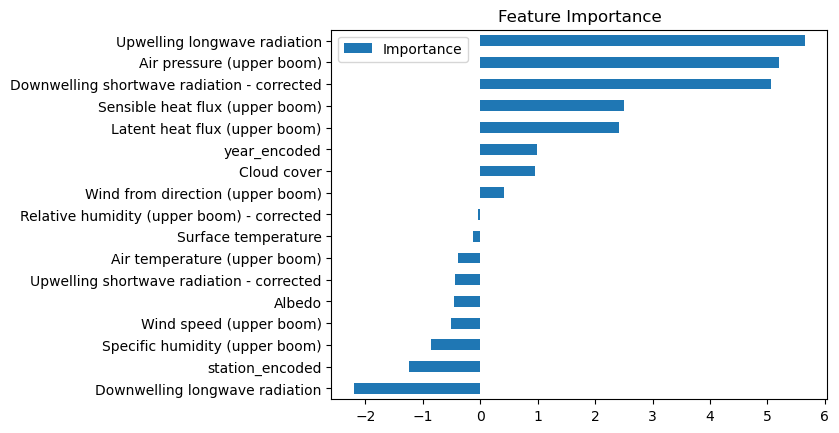

In [21]:
pd.options.mode.chained_assignment = None  # default='warn'


from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.util import Surv
from sksurv.metrics import cumulative_dynamic_auc
from sksurv.metrics import concordance_index_censored

df, features, target = preprocessing_melt(data, start_end='start',lags=False)
X_train, X_test, y_train, y_test = custom_train_test_split(df, features, target, method='by_year')

# Split the data into features (covariates) and the target variables (event and time_to_event)
covariates = X_train  
time_to_event = y_train['time_to_event']
event = y_train['event_True']
# Create a structured array for the target variables
y = Surv.from_arrays(event, time_to_event)

#[0.1, 0.5, 0.7, 1.0],


# Fit the Cox proportional hazards model
coxph = CoxPHSurvivalAnalysis(alpha=0.7)
coxph.fit(X_train, y)

# Print the model coefficients
#print("Model coefficients:", coxph.coef_)

time_to_event_test = y_test['time_to_event']
event_test = y_test['event_True'].astype('bool')


prediction = coxph.predict(X_test)
result = concordance_index_censored(event_test, time_to_event_test, prediction)
print("C-index:", result[0])

f1 = pd.DataFrame(data=coxph.coef_,
        index=features.columns,
        columns=['Importance']).sort_values(by='Importance',ascending=False)

#display(f1)
#display(X_test)

f1.sort_values('Importance').plot(kind='barh',title='Feature Importance')
# Get the estimated survival functions for the test dataset
#predicted_survival = coxph.predict_survival_function(X_test.loc[(X_test.index == 14945) | (X_test.index == 14946)])
#predicted_survival = coxph.predict_survival_function(X_test)
#Print the predicted survival functions
#survival_dfs = [survival_array for survival_array in predicted_survival]
#print(survival_dfs[0])



#for i, surv_func in enumerate(predicted_survival):
#    print(f"Survival function for subject {i}:")
#    print(surv_func)
#    print()


# Survival analysis coxPHSurvival melt end date

filtered out for station KAN_L max_year 2023 min_year 2008
filtered out for station NUK_L max_year 2023 min_year 2007
filtered out for station NUK_U max_year 2022 min_year 2007
filtered out for station QAS_L max_year 2023 min_year 2007
filtered out for station QAS_U max_year 2023 min_year 2008
C-index: 0.769112547042829


<Axes: title={'center': 'Feature Importance'}>

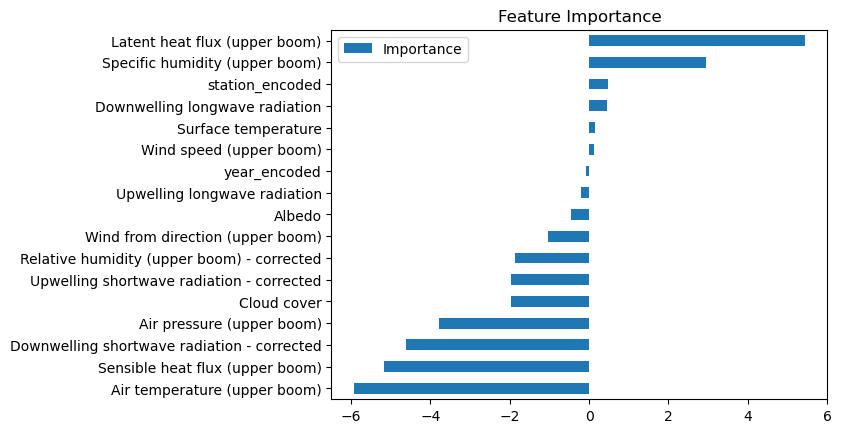

In [22]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.util import Surv
from sksurv.metrics import cumulative_dynamic_auc
from sksurv.metrics import concordance_index_censored

df, features, target = preprocessing_melt(data, start_end='end',lags=False)
X_train, X_test, y_train, y_test = custom_train_test_split(df, features, target, method='by_year')

# Split the data into features (covariates) and the target variables (event and time_to_event)
covariates = X_train  
time_to_event = y_train['time_to_event']
event = y_train['event_True']

# Create a structured array for the target variables
y = Surv.from_arrays(event, time_to_event)

#[0.1, 0.5, 0.7, 1.0],

# Fit the Cox proportional hazards model
coxph = CoxPHSurvivalAnalysis(alpha=0.1)
coxph.fit(X_train, y)

# Print the model coefficients
#print("Model coefficients:", coxph.coef_)

time_to_event_test = y_test['time_to_event']
event_test = y_test['event_True'].astype('bool')

prediction = coxph.predict(X_test)
result = concordance_index_censored(event_test, time_to_event_test, prediction)
print("C-index:", result[0])

f1 = pd.DataFrame(data=coxph.coef_,
        index=features.columns,
        columns=['Importance']).sort_values(by='Importance',ascending=False)
#display(f1)

f1.sort_values('Importance').plot(kind='barh',title='Feature Importance')

# Make predictions on new data (if applicable)
# new_data = pd.DataFrame(...)  # Create a DataFrame with the same structure as 'covariates'
# predicted_survival = coxph.predict_survival_function(new_data)


# Survival Analysis Random Forrest

## Melt season start

filtered out for station KAN_L max_year 2023 min_year 2008
filtered out for station NUK_L max_year 2023 min_year 2007
filtered out for station NUK_U max_year 2022 min_year 2007
filtered out for station QAS_L max_year 2023 min_year 2007
filtered out for station QAS_U max_year 2023 min_year 2008
0.7825161292749375


,Importance
Downwelling shortwave radiation - corrected,0.229554
station_encoded,0.191052
Air pressure (upper boom),0.135909
Upwelling shortwave radiation - corrected,0.093810
year_encoded,0.084010
Albedo,0.074756
Downwelling longwave radiation,0.061681
Air temperature (upper boom),0.054306
Wind from direction (upper boom),0.019788
Upwelling longwave radiation,0.014804


<Axes: title={'center': 'Feature Importance'}>

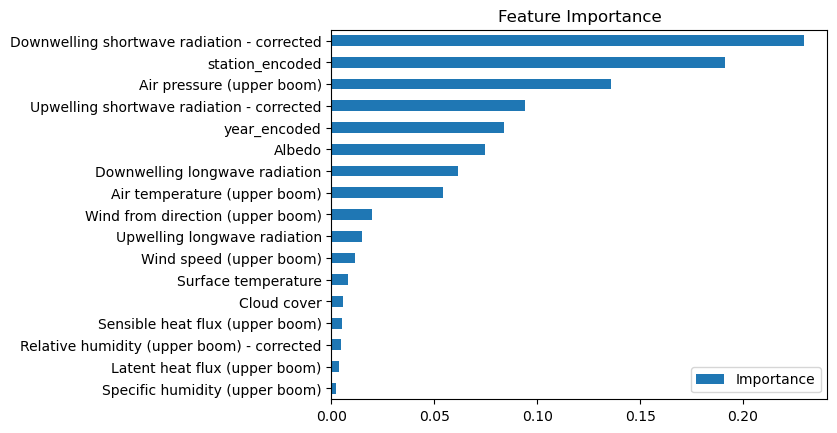

In [23]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

df, features, target = preprocessing_melt(data, start_end='start',lags=False)
X_train, X_test, y_train, y_test = custom_train_test_split(df, features, target,method='by_year')

y_train_array = y_train[['event_True','time_to_event']].to_records(index=False)

gbsa = GradientBoostingSurvivalAnalysis(
    learning_rate=0.1,
    max_depth=3,
    n_estimators=100,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42)
gbsa.fit(X_train, y_train_array)

# Make predictions
prediction = gbsa.predict(X_test)

# Compute the concordance index
result = concordance_index_censored(y_test['event_True'], y_test['time_to_event'], prediction)
print(result[0])

f1 = pd.DataFrame(data=gbsa.feature_importances_,
        index=features.columns,
        columns=['Importance']).sort_values(by='Importance',ascending=False)
display(f1)

f1.sort_values('Importance').plot(kind='barh',title='Feature Importance')

In [361]:
test = pd.DataFrame()
test[['event','time_to_event']] = y_test[['event','time_to_event']]
test['result'] = prediction

display(test.iloc[270:350].tail(30))


,event,time_to_event,result
3239,0,20.0,2.563155
3240,0,19.0,2.709328
3241,0,18.0,2.893399
3242,0,17.0,3.228808
3243,0,16.0,3.461294
3244,0,15.0,3.585402
3245,0,14.0,3.620280
3246,0,13.0,3.761090
3247,0,12.0,3.737856
3248,0,11.0,3.468291


# Survival gradient end

filtered out for station KPC_L max_year 2023 min_year 2008
filtered out for station SCO_L max_year 2023 min_year 2008
filtered out for station SCO_U max_year 2023 min_year 2008
C-index: 0.8461563124850618


,Importance
Upwelling shortwave radiation - corrected,0.246423
Downwelling shortwave radiation - corrected,0.236206
Upwelling longwave radiation,0.075367
year_encoded,0.067891
Downwelling longwave radiation,0.067718
Wind from direction (upper boom),0.055945
Cloud cover,0.048771
Specific humidity (upper boom),0.044228
Albedo,0.038987
station_encoded,0.034694


<Axes: title={'center': 'Feature Importance'}>

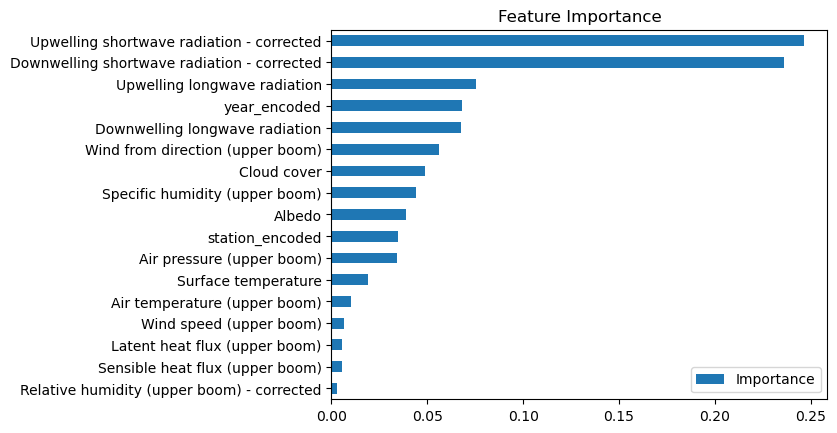

In [348]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

df, features, target = preprocessing_melt(data, start_end='end',lags=False)
X_train, X_test, y_train, y_test = custom_train_test_split(df, features, target, method='by_year')


y_train_array = y_train[['event_True','time_to_event']].to_records(index=False)

gbsa = GradientBoostingSurvivalAnalysis(
    learning_rate=0.1,
        max_depth=5,
        n_estimators=50,
        min_samples_split=2,
        min_samples_leaf=3,
        random_state=42)

gbsa.fit(X_train, y_train_array)

# Make predictions
prediction = gbsa.predict(X_test)

# Compute the concordance index
result = concordance_index_censored(y_test['event_True'], y_test['time_to_event'], prediction)
print("C-index:", result[0])

f1 = pd.DataFrame(data=gbsa.feature_importances_,
        index=features.columns,
        columns=['Importance']).sort_values(by='Importance',ascending=False)
display(f1)

f1.sort_values('Importance').plot(kind='barh',title='Feature Importance')

# XGB Regressor Gridsearch
_________________________________
## Melt Season Start

In [7]:
# start melt season gridsearch
from sklearn.model_selection import KFold


df, features, target = preprocessing_melt(data, start_end='start',lags=7)
#X_train, X_test, y_train, y_test = custom_train_test_split(df, features, target, by_year=True)


# Create TimeSeriesSplit object
cv = KFold(n_splits=3, shuffle=False)#, random_state=42)

# Define the XGBRegressor model
xgb_model = xgb.XGBRegressor()

# Define the parameter grid for the grid search
param_grid = {
    'learning_rate': [0.01], #, 0.1],
    'max_depth': [3, 5], #, 7],
    'n_estimators': [200, 300, 400], # 100,
    'subsample': [0.8, 1.0], #0.5,
    'colsample_bytree': [0.8, 1.0], #, 0.5],
    'reg_alpha': [0.5, 1.0],
    'reg_lambda': [0.5, 1.0],
    'min_child_weight':[3, 5] # 1
}

# Set up the grid search with TimeSeriesSplit for cross-validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=cv,
    verbose=3,
    n_jobs=-1
)

# Fit the grid search to the data
grid_search.fit(features, target['time_to_event'])

# Print the best parameters and corresponding score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

rmse = np.sqrt(np.abs(grid_search.best_score_))
print("Best RMSE:", rmse)

filtered out for station KPC_L max_year 2023 min_year 2008
filtered out for station SCO_L max_year 2023 min_year 2008
filtered out for station SCO_U max_year 2023 min_year 2008
Fitting 3 folds for each of 192 candidates, totalling 576 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'reg_alpha': 0.5, 'reg_lambda': 1.0, 'subsample': 0.8}
Best score: -19.432126444393553
Best RMSE: 4.408188567245457


In [8]:
# Print the best parameters and corresponding score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

rmse = np.sqrt(np.abs(grid_search.best_score_))
print("Best RMSE:", rmse)

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'reg_alpha': 0.5, 'reg_lambda': 1.0, 'subsample': 0.8}
Best score: -19.432126444393553
Best RMSE: 4.408188567245457


In [9]:
# start melt season gridsearch
from sklearn.model_selection import KFold


df, features, target = preprocessing_melt(data, start_end='start',lags=7)
#X_train, X_test, y_train, y_test = custom_train_test_split(df, features, target, by_year=True)


# Create TimeSeriesSplit object
cv = KFold(n_splits=3, shuffle=False)#, random_state=42)

# Define the XGBRegressor model
xgb_model = xgb.XGBRegressor()

# Define the parameter grid for the grid search
param_grid = {
    'learning_rate': [0.01], #, 0.1],
    'max_depth': [3, 5], #, 7],
    'n_estimators': [200, 300, 400], # 100,
    'subsample': [0.8, 1.0], #0.5,
    'colsample_bytree': [0.8, 1.0], #, 0.5],
    'reg_alpha': [0.5, 1.0],
    'reg_lambda': [0.5, 1.0],
    'min_child_weight':[3, 5] # 1
}

# Set up the grid search with TimeSeriesSplit for cross-validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='explained_variance',
    cv=cv,
    verbose=3,
    n_jobs=-1
)

# Fit the grid search to the data
grid_search.fit(features, target['time_to_event'])

# Print the best parameters and corresponding score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

rmse = np.sqrt(np.abs(grid_search.best_score_))
print("Best RMSE:", rmse)

filtered out for station KPC_L max_year 2023 min_year 2008
filtered out for station SCO_L max_year 2023 min_year 2008
filtered out for station SCO_U max_year 2023 min_year 2008
Fitting 3 folds for each of 192 candidates, totalling 576 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'reg_alpha': 0.5, 'reg_lambda': 1.0, 'subsample': 0.8}
Best score: 0.6959975482942214
Best RMSE: 0.8342646752045908


In [10]:
# Print the best parameters and corresponding score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

rmse = np.sqrt(np.abs(grid_search.best_score_))
print("Best RMSE:", rmse)

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'reg_alpha': 0.5, 'reg_lambda': 1.0, 'subsample': 0.8}
Best score: 0.6959975482942214
Best RMSE: 0.8342646752045908


## Melt Season End

In [105]:
# start melt season gridsearch

df, features, target = preprocessing_melt(data, start_end='end',lags=14)
#X_train, X_test, y_train, y_test = custom_train_test_split(df, features, target, by_year=True)


# Create TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=3)

# Define the XGBRegressor model
xgb_model = xgb.XGBRegressor()

# Define the parameter grid for the grid search
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0.5, 1.0],
    'reg_lambda': [0.5, 1.0],
    'min_child_weight':[1, 3, 5]
}

# Set up the grid search with TimeSeriesSplit for cross-validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error', 
    cv=tscv,
    verbose=3,
    n_jobs=-1
)

# Fit the grid search to the data
grid_search.fit(features, target['time_to_event'])

# Print the best parameters and corresponding score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

rmse = np.sqrt(np.abs(grid_search.best_score_))
print("Best RMSE:", rmse)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 200, 'reg_alpha': 0.5, 'reg_lambda': 1.0, 'subsample': 1.0}
Best score: -116.80159165204347
Best RMSE: 10.807478505740526


In [106]:
# Print the best parameters and corresponding score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

rmse = np.sqrt(np.abs(grid_search.best_score_))
print("Best RMSE:", rmse)

Best parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 200, 'reg_alpha': 0.5, 'reg_lambda': 1.0, 'subsample': 1.0}
Best score: -116.80159165204347
Best RMSE: 10.807478505740526


# GradientBoostingSurvivalAnalysis gridsearch

## Melt season start

In [101]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
import itertools

df, features, target = preprocessing_melt(data, start_end='start',lags=False)
target = target[['event_True','time_to_event']]
X_train, X_test, y_train, y_test = custom_train_test_split(df, features, target, by_year=True)


y_train_array = y_train[['event_True','time_to_event']].to_records(index=False)


def manual_grid_search(X_train, y_train_array, X_test, y_test):
    learning_rates = [0.01, 0.1]
    max_depths = [3, 5]
    n_estimators = [50, 100]
    min_samples_splits = [2, 5]
    min_samples_leafs = [1, 3]

    best_hyperparameters = None
    best_c_index = -1

    for params in itertools.product(learning_rates, max_depths, n_estimators, min_samples_splits, min_samples_leafs):
        learning_rate, max_depth, n_estimator, min_samples_split, min_samples_leaf = params

        gbsa = GradientBoostingSurvivalAnalysis(
            learning_rate=learning_rate,
            max_depth=max_depth,
            n_estimators=n_estimator,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )

        gbsa.fit(X_train, y_train_array)
        predictions = gbsa.predict(X_test)
        c_index = concordance_index_censored(y_test['event_True'], y_test['time_to_event'], predictions)[0]

        #print('Learning_rate:', learning_rate)
        #print('max_depth:',max_depth)
        #print('n_estimators:',n_estimators)
        #print('min_samples_split',min_samples_split)
        #print('min_samples_leaf', min_samples_leaf)
        #print(c_index)

        if c_index > best_c_index:
            best_c_index = c_index
            best_hyperparameters = params

    return best_hyperparameters, best_c_index

# Usage example

best_params, best_c_index = manual_grid_search(X_train, y_train_array, X_test, y_test)
print("Best hyperparameters:", best_params)
print("Best C-index:", best_c_index)

Best hyperparameters: (0.1, 3, 100, 2, 1)
Best C-index: 0.9394051798370537


## Melt season end

In [100]:
df, features, target = preprocessing_melt(data, start_end='end',lags=False)
target = target[['event_True','time_to_event']]
X_train, X_test, y_train, y_test = custom_train_test_split(df, features, target, by_year=True)


y_train_array = y_train[['event_True','time_to_event']].to_records(index=False)


def manual_grid_search(X_train, y_train_array, X_test, y_test):
    learning_rates = [0.01, 0.1]
    max_depths = [3, 5]
    n_estimators = [50, 100]
    min_samples_splits = [2, 5]
    min_samples_leafs = [1, 3]

    best_hyperparameters = None
    best_c_index = -1

    for params in itertools.product(learning_rates, max_depths, n_estimators, min_samples_splits, min_samples_leafs):
        learning_rate, max_depth, n_estimator, min_samples_split, min_samples_leaf = params

        gbsa = GradientBoostingSurvivalAnalysis(
            learning_rate=learning_rate,
            max_depth=max_depth,
            n_estimators=n_estimator,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )

        gbsa.fit(X_train, y_train_array)
        predictions = gbsa.predict(X_test)
        c_index = concordance_index_censored(y_test['event_True'], y_test['time_to_event'], predictions)[0]

        #print('Learning_rate:', learning_rate)
        #print('max_depth:',max_depth)
        #print('n_estimators:',n_estimators)
        #print('min_samples_split',min_samples_split)
        #print('min_samples_leaf', min_samples_leaf)
        #print(c_index)

        if c_index > best_c_index:
            best_c_index = c_index
            best_hyperparameters = params

    return best_hyperparameters, best_c_index

# Usage example

best_params, best_c_index = manual_grid_search(X_train, y_train_array, X_test, y_test)
print("Best hyperparameters:", best_params)
print("Best C-index:", best_c_index)

Best hyperparameters: (0.1, 5, 50, 2, 3)
Best C-index: 0.885528472888119


Month
1          NaN
2          NaN
3     0.795062
4     0.764239
5     0.724837
6     0.542907
7     0.401691
8     0.440204
9     0.586213
10         NaN
11         NaN
12         NaN
Name: Albedo, dtype: float64